# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


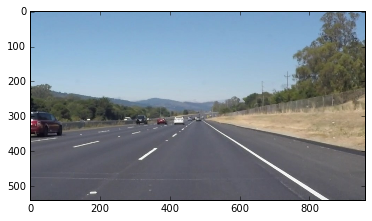

In [8]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [204]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def create_lines(img, lines, color=[0, 0, 255], thickness=10):
    """
   This function creates extrapolated lines 
   
   !! Note !!
   The extrapolation can cause lines to pass beyond the masked scope prior to Hough-Transform
   
   ?? Masking can be applied again (?) after if needed ??
   
    """
    
    ## Array Initialization
    left_lines_info = []
    right_lines_info = []
    left_lines =[]
    right_lines=[]
    right_ave = []
    left_ave = []

    ## Loop through Hough_Transform Output, create line y=Mx+B information along with line length
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            line_length = math.hypot(y2 - y1, x2 - x2) #Python math function
            # With a slope greater then 0.5, this line will be on the right side of the road from the camera's perspective
            if (slope > 0.5):
                line_input = (slope,intercept,line_length)
                right_lines_info.append(line_input)
            # With a slope less then 0.5, this line will be on the left side of the road from the camera's perspective
            elif (slope < -0.5):
                line_input = (slope,intercept,line_length)
                left_lines_info.append(line_input)
    
    ##Call averaging functions
    right_ave = side_average(right_lines_info)
    left_ave = side_average(left_lines_info)
    #print("right",right_ave)
    #print("left",left_ave)
    
    ##Extrapolate lines
    right_lines = side_line_extrap(right_ave)
    left_lines = side_line_extrap(left_ave)
   
    ##Add right and left lines onto the image
    for line in right_lines:
        cv2.line(img, (line[0],line[1]), (line[2], line[3]), color, thickness)
    for line in left_lines:
        cv2.line(img, (line[0],line[1]), (line[2], line[3]), color, thickness)

def side_average (line_info):
    """
    In this function, a 'sides' lines are averaged
    
    In this rudimentary averaging application, the hough_transform's output for 'line length'
    is utilized for a simple weighting
    
    """
    ## Initialize variables
    column = 2 #Column index 2 points to line lenghts
    slope = 0
    intercept = 0
    ## Sum all line lengths for averaging info
    total_length = sum(row[column] for row in line_info)
    ## Loop to accumulate averaging slopes and intercepts
    for line in line_info:
        slope += line[0] *line[2]/total_length
        intercept += line[1] * line[2] / total_length
    
    return (slope,intercept)
        
def side_line_extrap(line_info):
    """
    Simple function to extrapolate a line segment utilizing the natural borders of the forced horizon
    and the bottom of the image
    """
    
    ## Initialization
    horizon_point_full = []
    bottom_point_full = []
    line_out = []
    
    ## Find x coords for each two points as y points are simply the forced boundaries
    horizon_point_x = int((MASK_Offset_Horizon - line_info[1]) / line_info[0])
    bottom_point_x = int((MASK_Offset_BottomHorizon - line_info[1]) / line_info[0])
    append_cheat = [horizon_point_x,MASK_Offset_Horizon,bottom_point_x,MASK_Offset_BottomHorizon] #To simplify append
    line_out.append(append_cheat)
    
    return line_out
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    create_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [181]:
import os
os.listdir("test_images/")

['OUTPUT_SolidWhiteCurve.jpg',
 'OUTPUT_SolidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

right (0.59879790397961619, 17.482358167696454)
left (-0.78513384978905976, 689.09069979789263)


True

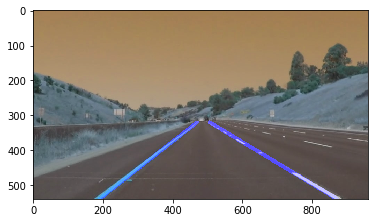

In [193]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import csv
%matplotlib inline

## CONSTANTS START
# Gaussian
kernel_size = 5 #Result from homework lesson
# Canny Edge
low_threshold = 25
high_threshold = 75
# Hough
rho = 2
theta = np.pi/180
threshold = 15
min_line_length = 50
max_line_gap = 40
## CONSTANTS END

## INIT START
# Masking
global MASK_Offset_BottomHorizon
global MASK_Offset_Horizon
MASK_Offset_Horizon_Correction = 50
MASK_Offset_BotLeft = 50
MASK_Offset_BotRight = 50
MASK_Offset_TopLeft = 25
MASK_Offset_TopRight = 25
ignore_mask_color = 255
# Image Info
image_info = 'test_images/whitecarLaneSwitch.jpg'
output_info = 'test_images/OUTPUT_whiteCarLaneSwitch.jpg'
## INIT END

## Base image info and Masking parameter setup
image = cv2.imread(image_info)
ysize = image.shape[0]
xsize = image.shape[1]
MASK_Offset_Horizon = int(ysize / 2 + MASK_Offset_Horizon_Correction)
MASK_Offset_BottomHorizon = ysize


# print('This image is with dimesions:', image.shape) # Used for testing
## GRAYSCALE
## Utilize OpenCV for grayscale conversion
image_gray = grayscale(image)

## GAUSSIAN SMOOTHING
## Utilize OpenCV for gaussian smoothing
blur_gray = gaussian_blur(image_gray,kernel_size)

## CANNY EDGE
## Utilize OpenCV for Canny Edge Detection
edges = canny(blur_gray,low_threshold,high_threshold)

## MASKING
## Utilize numpy for init of mask of zero's for targetted image extraction
mask = np.zeros_like(edges)

## Create four sided polygon array for targetted image extraction
vertices = np.array([[(MASK_Offset_BotLeft,MASK_Offset_BottomHorizon),(xsize/2-MASK_Offset_TopLeft,MASK_Offset_Horizon),
                      (xsize/2+MASK_Offset_TopRight,MASK_Offset_Horizon),(xsize-MASK_Offset_BotRight, MASK_Offset_BottomHorizon)]],
                    dtype=np.int32)
cv2.fillPoly(mask,vertices,ignore_mask_color)
masked_edges = cv2.bitwise_and(edges,mask)


line_image = np.copy(image)*0

#hough_out = hough_extrap(masked_edges,rho,theta,threshold,min_line_length,max_line_gap,image)
hough_out = hough_lines(masked_edges,rho,theta,threshold,min_line_length,max_line_gap)

# hough_gray = grayscale(hough_out)
#fl = open('hough_output.csv', 'w')

#writer = csv.writer(fl)
#for values in hough_gray:
#   writer.writerow(values)

#fl.close() 


weighted_out = weighted_img (hough_out,image)
plt.imshow(weighted_out)
cv2.imwrite(output_info,weighted_out)



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [194]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [206]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    ## CONSTANTS START
    # Gaussian
    kernel_size = 5 #Result from homework lesson
    # Canny Edge
    low_threshold = 25
    high_threshold = 75
    # Hough
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 50
    max_line_gap = 40
    ## CONSTANTS END

    ## INIT START
    # Masking
    global MASK_Offset_BottomHorizon
    global MASK_Offset_Horizon
    MASK_Offset_Horizon_Correction = 50
    MASK_Offset_BotLeft = 50
    MASK_Offset_BotRight = 50
    MASK_Offset_TopLeft = 25
    MASK_Offset_TopRight = 25
    ignore_mask_color = 255
    # Image Info
    #image_info = 'test_images/whitecarLaneSwitch.jpg'
    #output_info = 'test_images/OUTPUT_whiteCarLaneSwitch.jpg'
    ## INIT END

    ## Base image info and Masking parameter setup
    # image = cv2.imread(image_info)
    ysize = image.shape[0]
    xsize = image.shape[1]
    MASK_Offset_Horizon = int(ysize / 2 + MASK_Offset_Horizon_Correction)
    MASK_Offset_BottomHorizon = ysize


    # print('This image is with dimesions:', image.shape) # Used for testing
    ## GRAYSCALE
    ## Utilize OpenCV for grayscale conversion
    image_gray = grayscale(image)

    ## GAUSSIAN SMOOTHING
    ## Utilize OpenCV for gaussian smoothing
    blur_gray = gaussian_blur(image_gray,kernel_size)

    ## CANNY EDGE
    ## Utilize OpenCV for Canny Edge Detection
    edges = canny(blur_gray,low_threshold,high_threshold)

    ## MASKING
    ## Utilize numpy for init of mask of zero's for targetted image extraction
    mask = np.zeros_like(edges)

    ## Create four sided polygon array for targetted image extraction
    vertices = np.array([[(MASK_Offset_BotLeft,MASK_Offset_BottomHorizon),(xsize/2-MASK_Offset_TopLeft,MASK_Offset_Horizon),
                          (xsize/2+MASK_Offset_TopRight,MASK_Offset_Horizon),(xsize-MASK_Offset_BotRight, MASK_Offset_BottomHorizon)]],
                        dtype=np.int32)
    cv2.fillPoly(mask,vertices,ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges,mask)


    line_image = np.copy(image)*0

    #hough_out = hough_extrap(masked_edges,rho,theta,threshold,min_line_length,max_line_gap,image)
    hough_out = hough_lines(masked_edges,rho,theta,threshold,min_line_length,max_line_gap)

    # hough_gray = grayscale(hough_out)
    #fl = open('hough_output.csv', 'w')

    #writer = csv.writer(fl)
    #for values in hough_gray:
    #   writer.writerow(values)

    #fl.close() 


    weighted_out = weighted_img (hough_out,image)
    # plt.imshow(weighted_out)
    # cv2.imwrite(output_info,weighted_out)
    return weighted_out

Let's try the one with the solid white lane on the right first ...

In [207]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:04<00:00, 51.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 4.73 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [208]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


 91%|████████████████████████████████████▏   | 618/682 [00:12<00:01, 49.75it/s]

ValueError: cannot convert float NaN to integer

 91%|████████████████████████████████████▏   | 618/682 [00:30<00:03, 20.59it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))